In [2]:
import numpy as np
np.set_printoptions(precision=3)
import scipy
import scipy.ndimage
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import skimage.feature

In [3]:
def load_image(path):
    im = cv2.imread(path, 0)
    im = im / 255.
    return im

In [139]:

def standard_blob_detector(image, stds, threshold):
    (h,w) = image.shape
    #stds = [2 * (1.1 ** i) for i in range(15)]
    scale_space = np.zeros((h,w,len(stds)))
    for i in range(len(stds)):
        std = stds[i]
        scale_space[:,:,i] = ((std ** 2) * (scipy.ndimage.filters.gaussian_laplace(image, std))) ** 2
    
    max_vals = np.zeros(scale_space.shape)
    for i in range(len(stds)):
        level = scale_space[:,:,i]
        max_filter = scipy.ndimage.filters.rank_filter(level, -1, size=round(stds[i]*2))
        max_indices = (level == max_filter).nonzero()
        max_vals[:,:,i][max_indices] = level[max_indices]
    
    max_vals_final = np.zeros(max_vals.shape)
    count = 3
    for i in range(count, len(stds)-count):
        level = max_vals[:,:,i-count:i+count]
        max_filter = scipy.ndimage.filters.rank_filter(level, -1, size=(round(stds[i]*3), round(stds[i]*3), 2*count+1))
        max_indices = (level == max_filter).nonzero()
        max_vals_final[:,:,i-count:i+count][max_indices] = level[max_indices]
    
    """
    max_filter = scipy.ndimage.filters.rank_filter(max_vals, -1, size=(3,3,len(stds)))
    max_indices = (max_vals == max_filter).nonzero()
    max_vals_final[max_indices] = max_vals[max_indices]
    """
    
    max_vals = max_vals_final
    
    
    max_vals_condensed = np.max(max_vals, 2)
    max_indices_condensed = np.argmax(max_vals, 2)
    
    max_indices_condensed *= (max_vals_condensed > threshold)
    max_vals_condensed *= (max_vals_condensed > threshold)
    
    return max_indices_condensed
    
        

In [140]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()
    
    

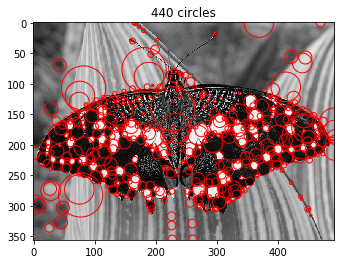

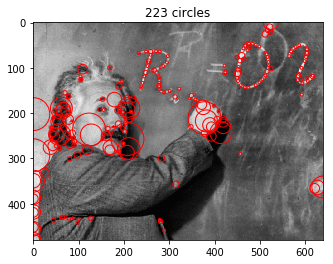

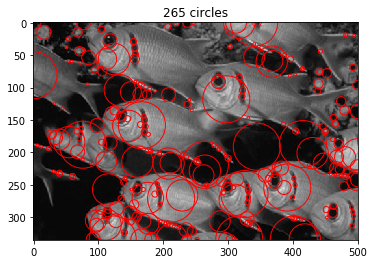

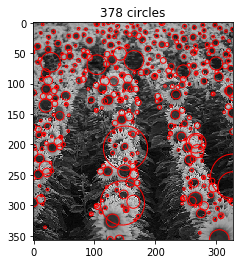

In [142]:
image_names = ['assignment2_images/butterfly.jpg', 'assignment2_images/einstein.jpg', 'assignment2_images/fishes.jpg', 'assignment2_images/sunflowers.jpg']
stds = [1.0 * (1.5 ** i) for i in range(10)]
rads = [stds[i] * (2 ** 0.5) for i in range(len(stds))]

thresholds = [0.02, 0.025, 0.015, 0.025]



for i in range(len(image_names)):
    im = load_image(image_names[i])
    max_indices_condensed = standard_blob_detector(im, stds, thresholds[i])
    (y,x) = indices = max_indices_condensed.nonzero()
    depths = max_indices_condensed[indices]
    my_stds = np.array([stds[depths[i]] for i in range(len(depths))])
    blob_arr = np.stack([y,x,my_stds]).T
    
    """
    new_blob_arr = skimage.feature.blob._prune_blobs(blob_arr, 0.8)
    
    (y, x, my_stds) = new_blob_arr.T
    
    my_rads = [my_stds[i] * (2 ** 0.5) for i in range(len(my_stds))]
    """
    
    my_rads = [rads[depths[i]] for i in range(len(depths))]
    show_all_circles(im, x, y, my_rads)
